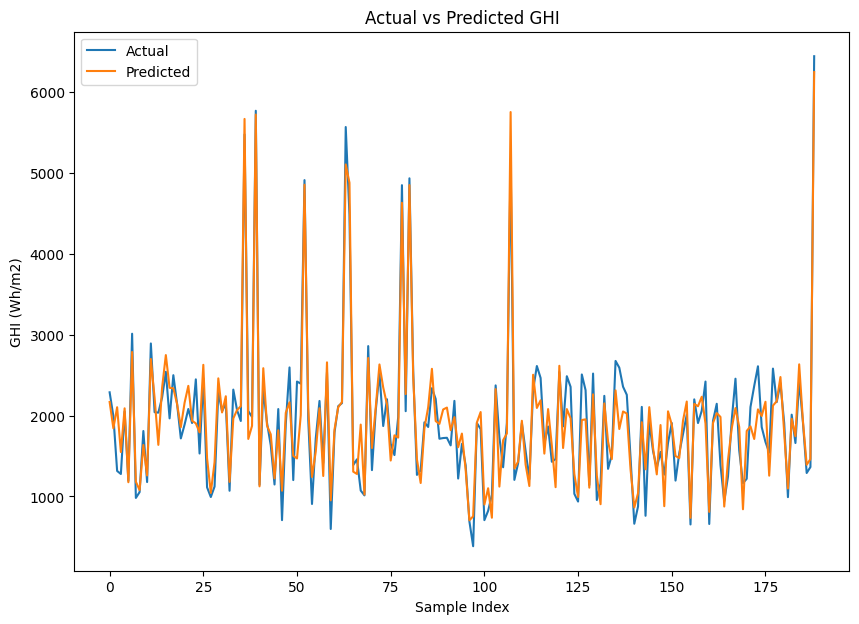

Random Forest MAE: 221.0249287903704, RMSE: 280.8131826264988, R²: 0.9094993852057965
Pseudo-Accuracy: 0.4973544973544973
                                      Importance
DNI (Wh/m2)                             0.355904
Barometric Pressure (mB (hPa equiv))    0.284025
Relative Humidity (%)                   0.211011
Air Temperature (C°)                    0.123899
Wind Speed at 3m (m/s)                  0.020775
DHI (Wh/m2)                             0.004386


Importance of Air Temperature: 0.12389859896197568
Confusion Matrix:
[[15  1  0  0  0  0  0  0  0]
 [18 30  5  0  0  0  0  0  0]
 [ 1 13 55  0  0  0  0  0  0]
 [ 0  2 25 12  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  1]
 [ 0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  1]]


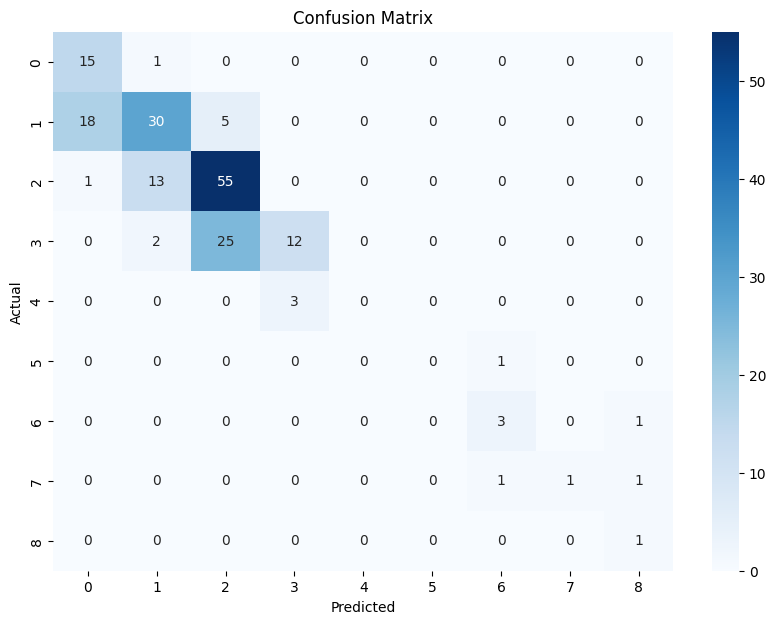

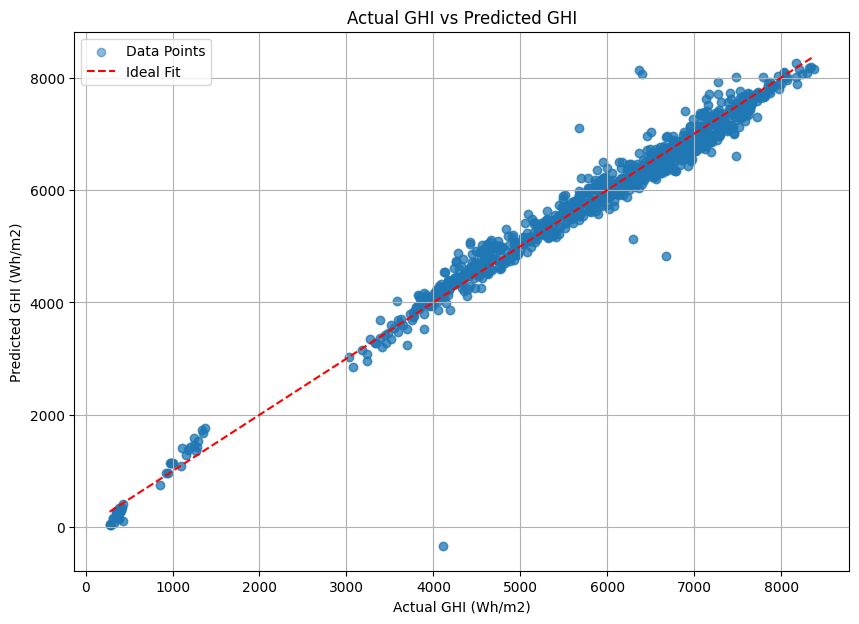

Fitted coefficients:
alpha0 = -797.0791648189622
alpha1 = 1.0375073017719674
alpha2 = 1.4582530561979463
alpha3 = 189.48193878014473
alpha4 = -0.00014001004355698838
alpha5 = -176.30422898804247
alpha6 = -39.151209409323194
beta1 = 0.047028393765853244
gamma1 = 0.00027706316057785085


      GHI  Predicted_GHI
0  5895.8    5582.028077
1  6252.5    6002.461657
2  6914.6    6708.911669
3  6362.0    6030.435869
4  6709.8    6479.453347
End of Execution




In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Load the dataset
df = pd.read_csv('C:/Users/Administrator/OneDrive/Desktop/OPEN-DATA-RCH/CLEANED_SOLAR_DATA/CLEAN_SOLAR_DATA_FINAL_PROCESSED.csv')

# Define features and target
features = ['Air Temperature (C°)', 'Wind Speed at 3m (m/s)', 'Relative Humidity (%)', 'Barometric Pressure (mB (hPa equiv))', 'DHI (Wh/m2)', 'DNI (Wh/m2)']
target = 'GHI (Wh/m2)'

#features = ['Air Temperature (CÂ°)', 'Wind Speed at 3m (m/s)', 'Relative Humidity (%)', 'Barometric Pressure (mB (hPa equiv))', 'DHI (Wh/m2)', 'DNI (Wh/m2)']
target = 'GHI (Wh/m2)'
# Split the data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Save the model
joblib.dump(rf, 'best_model.pkl')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('GHI (Wh/m2)')
plt.title('Actual vs Predicted GHI')
plt.legend()
plt.show()


# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Random Forest MAE: {mae}, RMSE: {rmse}, R²: {r2}')

tolerance = 0.10  # 10% tolerance
accurate_predictions = np.abs((y_test - y_pred) / y_test) < tolerance
pseudo_accuracy = np.mean(accurate_predictions)
print(f"Pseudo-Accuracy: {pseudo_accuracy}")

# Display feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=features, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

# Display the coefficient for air temperature (feature importance)
#air_temp_importance = feature_importances.loc['Air Temperature (CÂ°)', 'Importance']
air_temp_importance = feature_importances.loc['Air Temperature (C°)', 'Importance']
print("\n")
print(f'Importance of Air Temperature: {air_temp_importance}')


# Calculate and display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Since GHI is a continuous variable, we need to discretize it for confusion matrix
# Here, we categorize GHI into bins
y_test_bins = pd.cut(y_test, bins=10, labels=False)
y_pred_bins = pd.cut(pd.Series(y_pred), bins=10, labels=False)

#print(y_test_bins)
#print(y_pred_bins)

# Compute confusion matrix
cm = confusion_matrix(y_test_bins, y_pred_bins)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#-------------------

# Define the nonlinear GHI model
def ghi_model(X, alpha0, alpha1, alpha2, alpha3, beta1, alpha4, alpha5, alpha6, gamma1):
     with np.errstate(divide='ignore', invalid='ignore'):
         DNI, cos_theta, DHI, Temp, Humidity, Pressure, WindSpeed = X
         Temp = np.where(Temp == 0, 1e-10, Temp)  # Prevent divide by zero for log
         return (alpha0 + alpha1 * DNI * cos_theta + alpha2 * DHI +
            alpha3 * np.exp(beta1 * Temp) + alpha4 * Humidity**2 +
            alpha5 * np.log(Pressure) + alpha6 * WindSpeed**gamma1)

# Read data from CSV file

df = pd.read_csv('C:/Users/Administrator/OneDrive/Desktop/OPEN-DATA-RCH/CLEANED_SOLAR_DATA/CLEAN_SOLAR_DATA_GHI_COMPUTED.csv',delimiter=',')

# Calculate cosine of solar zenith angle (cos_theta) if needed
# For simplicity, we'll assume a constant value here, but in practice, you should compute it based on the Date and Location
df['cos_theta'] = np.cos(np.deg2rad(45))  # Example, replace with actual calculation

# Select relevant columns and rename for clarity
df = df.rename(columns={
    'Air Temperature (CÂ°)': 'Temperature',
    #'Air Temperature (C°)': 'Temperature',
    'Wind Speed at 3m (m/s)': 'WindSpeed',
    'DHI (Wh/m2)': 'DHI',
    'DNI (Wh/m2)': 'DNI',
    'Relative Humidity (%)': 'Humidity',
    'Barometric Pressure (mB (hPa equiv))': 'Pressure',
    'GHI (Wh/m2)': 'GHI'
})

# Independent variables (X) and dependent variable (y)
X = df[['DNI', 'cos_theta', 'DHI', 'Temperature', 'Humidity', 'Pressure', 'WindSpeed']].values.T
y = df['GHI'].values

# Initial guesses for the coefficients
initial_guess = [50, 1, 0.5, 0.1, 0.05, 0.2, 0.05, 0.1, 1.0]

# Curve fitting
popt, pcov = curve_fit(ghi_model, X, y, p0=initial_guess)

# Function to predict GHI
def predict_ghi(df, popt):
    X = df[['DNI', 'cos_theta', 'DHI', 'Temperature', 'Humidity', 'Pressure', 'WindSpeed']].values.T
    predicted_ghi = ghi_model(X, *popt)
    return predicted_ghi

# Predict GHI for the sample data
df['Predicted_GHI'] = predict_ghi(df, popt)

# Plotting Actual GHI vs Predicted GHI
plt.figure(figsize=(10, 7))
plt.scatter(df['GHI'], df['Predicted_GHI'], alpha=0.5, label='Data Points')
plt.plot([df['GHI'].min(), df['GHI'].max()], [df['GHI'].min(), df['GHI'].max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual GHI (Wh/m2)')
plt.ylabel('Predicted GHI (Wh/m2)')
plt.title('Actual GHI vs Predicted GHI')
plt.legend()
plt.grid(True)
plt.show()

# Extract the fitted coefficients
alpha0, alpha1, alpha2, alpha3, beta1, alpha4, alpha5, alpha6, gamma1 = popt
print("Fitted coefficients:")
print("alpha0 =", alpha0)
print("alpha1 =", alpha1)
print("alpha2 =", alpha2)
print("alpha3 =", alpha3)
print("alpha4 =", alpha4)
print("alpha5 =", alpha5)
print("alpha6 =", alpha6)
print("beta1 =", beta1)
print("gamma1 =", gamma1)
print("\n")
print(df[['GHI', 'Predicted_GHI']].head(5))
print("End of Execution")
print("\n")

df.to_csv('C:/Users/Administrator/OneDrive/Desktop/OPEN-DATA-RCH/CLEANED_SOLAR_DATA/Non_linear_model_predicted_GHI2.csv')


=(-797.0791648189622) +1.0375073017719674*(Q2*AC2)+1.4582530561979463*N2+189.48193878014473*EXP(0.047028393765853244*G2)+(-0.00014001004355698838)*(Y2^2)+(-176.30422898804247)LN(AA2)+(-39.151209409323194)*(M2^0.00027706316057785085)